# Exploring The Data: Fake News Challenge

In today's project session, we are going to think more about the Fake News Challenge dataset (https://github.com/FakeNewsChallenge/fnc-1) and the task of classifying the stance of the body text relative to the claim made in the headline into one of four categories:
1. Agrees: The body text agrees with the headline.
2. Disagrees: The body text disagrees with the headline.
3. Discusses: The body text discuss the same topic as the headline, but does not take a position
4. Unrelated: The body text discusses a different topic than the headline

Today we will:
1. Look at the distribution of examples across stance classes
2. Think about the rules we, as humans, use to perform the article-headline classification challenge. We will then explore if these rules enable the computer to separate out the different stance classes. 

Anytime you see ``______ # TODO: FILL IN HERE.`` in the code, you should replace the ``______`` with your own code.

As always, ask your neighbors or an instructor if you have any questions!

### 1. Read in data

In [4]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os.path

pd.set_option('display.max_colwidth', -1)

In [6]:
# Function to create the training data if you don't already have it
def merge_data(stances_filename, bodies_filename, merged_filename):
    stances = pd.read_csv(stances_filename, encoding = "utf-8")
    bodies = pd.read_csv(bodies_filename, encoding = "utf-8")
    data = pd.merge(bodies, stances, on='Body ID')
    data.to_csv(merged_filename, index=False, encoding = "utf-8")

In [7]:
# Let's read in the dataset we created yesterday (and we will create it if it doesn't already exist; you may need to 
# adjust the file path if python cannot find the 'train_stances.csv' and 'train_bodies.csv' files):
if os.path.isfile('train_data.csv') == False:
    merge_data("train_stances.csv", "train_bodies.csv", "train_data.csv")

In [11]:
# Read in the training data and separate out the training data according to the value of the Stance variable:
train_data = pd.read_csv("train_data.csv", encoding = "utf-8")

In [12]:
# Reminder: what do these datasets look like? Use a function that you encountered yesterday to display the first few 
# rows of the training dataset:
train_data.head() # TODO: FILL IN HERE 

,Body ID,articleBody,Headline,Stance
0,0,"A small meteorite crashed into a wooded area in Nicaragua's capital of Managua overnight, the government said Sunday. Residents reported hearing a mysterious boom that left a 16-foot deep crater near the city's airport, the Associated Press reports. \n\nGovernment spokeswoman Rosario Murillo said a committee formed by the government to study the event determined it was a ""relatively small"" meteorite that ""appears to have come off an asteroid that was passing close to Earth."" House-sized asteroid 2014 RC, which measured 60 feet in diameter, skimmed the Earth this weekend, ABC News reports. \nMurillo said Nicaragua will ask international experts to help local scientists in understanding what happened.\n\nThe crater left by the meteorite had a radius of 39 feet and a depth of 16 feet, said Humberto Saballos, a volcanologist with the Nicaraguan Institute of Territorial Studies who was on the committee. He said it is still not clear if the meteorite disintegrated or was buried.\n\nHumberto Garcia, of the Astronomy Center at the National Autonomous University of Nicaragua, said the meteorite could be related to an asteroid that was forecast to pass by the planet Saturday night.\n\n""We have to study it more because it could be ice or rock,"" he said.\n\nWilfried Strauch, an adviser to the Institute of Territorial Studies, said it was ""very strange that no one reported a streak of light. We have to ask if anyone has a photo or something.""\n\nLocal residents reported hearing a loud boom Saturday night, but said they didn't see anything strange in the sky.\n\n""I was sitting on my porch and I saw nothing, then all of a sudden I heard a large blast. We thought it was a bomb because we felt an expansive wave,"" Jorge Santamaria told The Associated Press.\n\nThe site of the crater is near Managua's international airport and an air force base. Only journalists from state media were allowed to visit it.","Soldier shot, Parliament locked down after gunfire erupts at war memorial",unrelated
1,0,"A small meteorite crashed into a wooded area in Nicaragua's capital of Managua overnight, the government said Sunday. Residents reported hearing a mysterious boom that left a 16-foot deep crater near the city's airport, the Associated Press reports. \n\nGovernment spokeswoman Rosario Murillo said a committee formed by the government to study the event determined it was a ""relatively small"" meteorite that ""appears to have come off an asteroid that was passing close to Earth."" House-sized asteroid 2014 RC, which measured 60 feet in diameter, skimmed the Earth this weekend, ABC News reports. \nMurillo said Nicaragua will ask international experts to help local scientists in understanding what happened.\n\nThe crater left by the meteorite had a radius of 39 feet and a depth of 16 feet, said Humberto Saballos, a volcanologist with the Nicaraguan Institute of Territorial Studies who was on the committee. He said it is still not clear if the meteorite disintegrated or was buried.\n\nHumberto Garcia, of the Astronomy Center at the National Autonomous University of Nicaragua, said the meteorite could be related to an asteroid that was forecast to pass by the planet Saturday night.\n\n""We have to study it more because it could be ice or rock,"" he said.\n\nWilfried Strauch, an adviser to the Institute of Territorial Studies, said it was ""very strange that no one reported a streak of light. We have to ask if anyone has a photo or something.""\n\nLocal residents reported hearing a loud boom Saturday night, but said they didn't see anything strange in the sky.\n\n""I was sitting on my porch and I saw nothing, then all of a sudden I heard a large blast. We thought it was a bomb because we felt an expansive wave,"" Jorge Santamaria told The Associated Press.\n\nThe site of the crater is near Managua's international airport and an air force base. Only journalists from state media were allowed to visit it.",Tourist

### 2. Stance variable distribution

Reminder: the goal of this challenge is to teach the computer to 'read' in article/headline pairs and predict the associated value of the Stance variable (UNRELATED/DISCUSS/AGREE/DISAGREE).  First, we should look at the number of examples that we have for each value of the stance variable that we can use for teaching the computer:

In [13]:
# Let's look at the distribution of stance variables in the dataset:
train_data.Stance.value_counts()

unrelated    36545
discuss      8909 
agree        3678 
disagree     840  
Name: Stance, dtype: int64

In [14]:
# And as a proportion of the rows in the dataset: (use an attribute of train_data that you learned about yesterday to
# divide the count values by the number of rows in the dataset)
train_data.Stance.value_counts()/train_data.shape[0] # TODO: FILL IN HERE

unrelated    0.731310
discuss      0.178280
agree        0.073601
disagree     0.016809
Name: Stance, dtype: float64

Thus, we have a very uneven dataset, with many more examples of UNRELATED article/headline pairs compared to DISCUSS/AGREE/DISAGREE article/headline pairs. We will discuss the consequences of this uneven distribution later.

### 3. Exploring the data - Can we find features that are different across stance groups?

In what follows, we are going to work with a reduced subset of the training dataset, which has an equal number of examples from each Stance category. We will return to working with the full dataset later.

#### 3a. Randomly sample 100 examples from each stance class

In [16]:
unrelated = train_data[train_data['Stance'] == 'unrelated'].sample(100)

In [18]:
discuss = train_data[train_data['Stance'] == 'discuss'].sample(100) # TODO: FILL IN HERE
agree = train_data[train_data['Stance'] == 'agree'].sample(100) # TODO: FILL IN HERE
disagree = train_data[train_data['Stance'] == 'disagree'].sample(100) # TODO: FILL IN HERE

In [21]:
# Check that each class has one hundred samples:
unrelated.shape[0] # TODO: FILL IN HERE
discuss.shape[0]
agree.shape[0]
disagree.shape[0]

100

#### 3b. What distinguishes each class? 
When headlines and articles are 'unrelated', is the proportion of words from the article contained in the headline different to that for other stance classes?

In [30]:
# Let's examine the proportion of words that are contained in a headline that are also contained in an article for 
# a headline-article example.  Let's create a function that reads in an example (single row in any of the dataframes we 
# created above) and returns the proportion of the headline that is contained in the article:
def find_headline_in_article_proportion(example):
    # Separate out all of the individual words in headline:
    headline_words = str.split(example['Headline'])
    # Separate out all of the individual words in the article:
    article_words = str.split(example['articleBody'])
    # Counter to count the number of words in the headline that are contained in the article
    counter = 0 
    # Now iterate through each of the words in the headline and check if the word also exists in the article
    for word in headline_words:
        if word in article_words:
            # If the word in the headline is contained in the article, add 1 to the counter
            counter += 1
    # Since the length of each headline is different, what we really want to compare across examples is the proportion 
    # of the headline that is contained in the article 
    proportion = counter/len(headline_words)
    return proportion

In [31]:
# Let's apply the function to all examples in each of the four dataframes we created above.
# We will save the results to a list:
proportions_unrelated = [] # Save results to this list
for i in range(unrelated.shape[0]):
    # Extract example
    this_example = unrelated.iloc[i]
    # Save result of calling find_headline_in_article_proportion() on example to proportions_unrelated list
    proportions_unrelated.append(find_headline_in_article_proportion(this_example))

In [34]:
# Now do the same for each of the other stance classes:
# discuss class
proportions_discuss= [] 
for i in range(discuss.shape[0]):
    this_example = discuss.iloc[i] # TODO: FILL IN HERE
    proportions_discuss.append(find_headline_in_article_proportion(this_example)) # TODO: FILL IN HERE

In [37]:
# agree class
proportions_agree= [] 
for i in range(agree.shape[0]): # TODO: FILL IN HERE
    this_example = agree.iloc[i]
    proportions_agree.append(find_headline_in_article_proportion(this_example))

In [36]:
# disagree class
proportions_disagree= [] # TODO: FILL IN HERE
for i in range(disagree.shape[0]):
    this_example = disagree.iloc[i]
    proportions_disagree.append(find_headline_in_article_proportion(this_example)) # TODO: FILL IN HERE

#### 3d. Visualize the differences in proportions across stance classes
We will create a boxplot to show the differences in proportions across stance classes

In [38]:
data_to_plot = [proportions_unrelated, proportions_agree, proportions_disagree, proportions_discuss] # TODO: FILL IN HERE

Text(0, 0.5, 'Proportion headline in article')

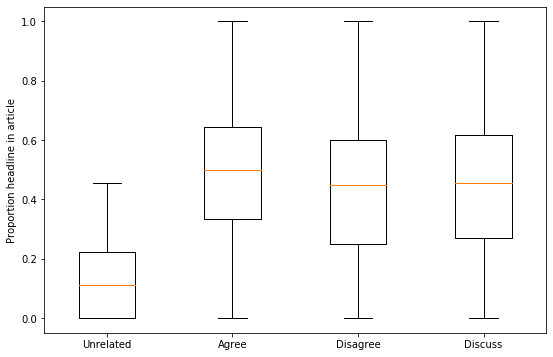

In [39]:
# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(data_to_plot)
# Set the xaxis tick marks
ax.set_xticklabels(['Unrelated', 'Agree', 'Disagree', 'Discuss'])
# Set the yaxis label
ax.set_ylabel('Proportion headline in article')

What do you notice from the boxplot? From the boxplot, could you come up with a rule for the computer to use in order to classify article-headline examples as UNRELATED/AGREE/DISAGREE/DISCUSS? What about if the challenge was only to classify pairs as either UNRELATED or RELATED (with RELATED = AGREE + DISAGREE + DISCUSS)? 

### Extra Challenge

"Extra challenge" sections are a more unguided exploration into the concepts we've discussed. You'll notice less scaffolding for the code -- try implementing these concepts from scratch, and feel free to ask your neighbors or an instructor if you have any questions!

After examining your boxplot's results and coming up with a rule for the computer to use in order to classify article-headline pairs as UNRELATED/RELATED, test out this rule on some examples from the training dataset. Is your rule able to correctly predict the true value of Stance for each example?